<a href="https://colab.research.google.com/github/NataliaTarasovaNatoshir/NataliaTarasovaNatoshir/blob/main/Answers_to_philosophical_questions_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

Note: This notebook uses TPU. In Colab, choose Runtime -> Change runtime type and verify that a TPU is selected.

# Overview

Do you want to ask philosophical questions to famous thinkers?

Let's use [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) architecture for NLP to find answers to a question among famous quotes by influencial thinkers!

In this Colab Notebook we will:


1.   Use TPU to efficiently train the model
2.   Fine-tune BERT to the specific task: "check if a sentence contains an answer to a question"
1.   Apply this tuned model to find quotes that are likely to contain an answer to the selected question





# Fine-tune BERT

[BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) is at its core a transformer language model with a variable number of encoder layers and self-attention heads. The architecture is "almost identical" to the original transformer implementation in Vaswani et al. (2017).

BERT was pretrained on two tasks: language modelling (15% of tokens were masked and BERT was trained to predict them from context) and next sentence prediction (BERT was trained to predict if a chosen next sentence was probable or not given the first sentence). As a result of the training process, BERT learns contextual embeddings for words. After pretraining, which is computationally expensive, BERT can be finetuned with less resources on smaller datasets to optimize its performance on specific tasks.

## Setup TPU

In [2]:
# for text preprocessing
!pip install -q -U tensorflow-text==2.7.3

In [3]:
# to use AdamW optimizer
!pip install -q -U tf-models-official==2.7.0

In [4]:
!pip install -U tfds-nightly

In [5]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [6]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [7]:
# connect to TPU
if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


## Tune BERT model

To apply BERT to our task we need to make these steps:


1.   Prepare text inputs in a way suitable for BERT 
2.   Process inputs by BERT encoder
2.   Train our neural network to use encoded unputs to define whether a sentence contains an answer  



### Text preprocessing

First, let's use BERT preprocessing layers to preprocess inputs for later use

In [8]:
# BERT model - encoder
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
# Preprocessing for encoder
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [9]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


In [10]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


In [11]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Pack inputs
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(segments)
  return tf.keras.Model(input_segments, model_inputs)

In [12]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['test question text']),
             np.array(['test answer text'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_mask', 'input_word_ids', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 3231 3160 3793  102 3231 3437 3793  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


Below we can see how we preprocess our inputs

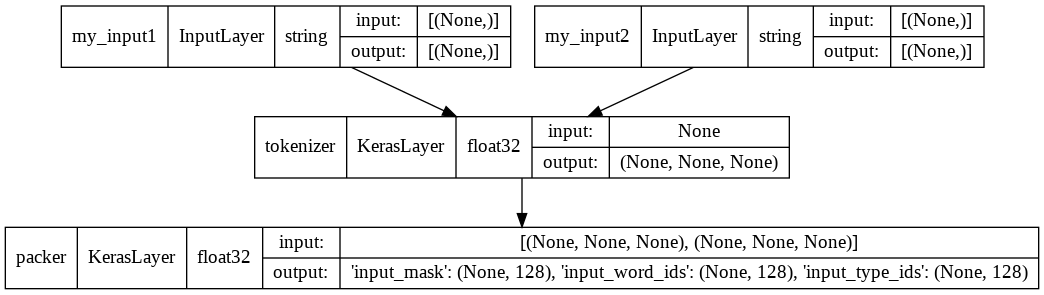

In [13]:
tf.keras.utils.plot_model(test_preprocess_model, show_shapes=True, show_dtype=True)

To train our model we will first load a datasest and then preprocess it with our preprocessing model 

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

### Model building

To make prediction we will use BERT encoder and then Dense layer to predict a class label for every question-sentence pair

In [15]:
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

Let's see how our untrained model works so far:

In [16]:
test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7581965  0.97388995]], shape=(1, 2), dtype=float32)


### Load dataset for model training

To train our model we will use on of the [GLUE datasets](https://gluebenchmark.com/):

[QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference): The task is to determine whether the context sentence contains the answer to the question.

In [17]:
tfds_name = 'glue/qnli'

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/qnli from TFDS
This dataset has 115669 examples
Number of classes: 2
Features ['question', 'sentence']
Splits ['train', 'validation', 'test']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/104743 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/qnli/2.0.0.incompletePVLP88/glue-train.tfrecord*...:   0%|          | 0/1…

Generating validation examples...:   0%|          | 0/5463 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/qnli/2.0.0.incompletePVLP88/glue-validation.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/5463 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/qnli/2.0.0.incompletePVLP88/glue-test.tfrecord*...:   0%|          | 0/54…

Dataset glue downloaded and prepared to ~/tensorflow_datasets/glue/qnli/2.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/qnli dataset
['entailment', 'not_entailment']

sample row 1
b'The period of time from 1200 to 1000 BCE is known as what?'
b'In the Iron Age'
label: 0 (entailment)

sample row 2
b"Who was the London Weekend Television's managing director?"
b'The managing director of London Weekend Television (LWT), Greg Dyke, met with the representatives of the "big five" football clubs in England in 1990.'
label: 0 (entailment)

sample row 3
b'What percentage of Swiss people claimed no church affiliation in 2012?'
b'21.4% in 2012 declared themselves as unchurched i.e. not affiliated with any church or other religious body (Agnostic, Atheist, or just not related to any official religion).'
label: 0 (entailment)

sample row 4
b"What is Nigeria's local vehicle manufacturer?"
b'In 2013, Nigeria introduced a policy regarding import duty on vehicles to enco

In [20]:
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)

  return metrics, loss

### Train model

In [21]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)
  
  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


3273/3273 [==============================] - 362s 88ms/step - loss: 0.4016 - accuracy: 0.8314 - val_loss: 0.2576 - val_accuracy: 0.9079
Epoch 2/3
3273/3273 [==============================] - 272s 83ms/step - loss: 0.2434 - accuracy: 0.9204 - val_loss: 0.2582 - val_accuracy: 0.9142
Epoch 3/3
3273/3273 [==============================] - 270s 82ms/step - loss: 0.1539 - accuracy: 0.9555 - val_loss: 0.3484 - val_accuracy: 0.9142


We may save our model and variables to Colab host

In [25]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False,
                      options=save_options)

Saving ./my_models/glue_qnli_bert_en_uncased_L-12_H-768_A-12


# Use famous quotes as answers

To find possible answers we may use famous quotes by influencial thinkers 

In [174]:
# loads quotes directly from GitHub to pandas.DataFrame
quotes_url = 'https://github.com/akhiltak/inspirational-quotes/raw/master/Quotes.csv'
quotes_df = pd.read_csv(quotes_url, sep=';', header=0)

In [175]:
# preprocess quotes
quotes_df.drop(['GENRE'], axis=1, inplace=True)
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: 'said' not in x)]
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: "'" not in x)]
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: '"' not in x)]

# to obtain more generalizable answers let's remove quotes about contemporary USA politics
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: 'republican' not in x.lower())]
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: 'jesus' not in x.lower())]
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: 'democrat' not in x.lower())]
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: 'american' not in x.lower())]
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: 'Bush' not in x)]
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: 'soviet' not in x.lower())]
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: 'cia' not in x.lower())]
quotes_df = quotes_df[quotes_df['QUOTE'].apply(lambda x: 'kgb' not in x.lower())]

# remove duplicates
quotes_df = quotes_df.drop_duplicates()
quotes_df.head()

,QUOTE,AUTHOR
1,"Anyone who stops learning is old, whether at t...",Henry Ford
2,Wrinkles should merely indicate where smiles h...,Mark Twain
3,True terror is to wake up one morning and disc...,Kurt Vonnegut
5,"As I grow older, I pay less attention to what ...",Andrew Carnegie
6,How incessant and great are the ills with whic...,C. S. Lewis


In [176]:
len(quotes_df)

34526

Taken a question we may find quotes that are more likely to contain an answer. As we have a lot of possible quotes (30k+ unique quotes) we may work with a smaller random subsample to make the process faster

In [178]:
def get_answers(question, quote_db, top_answers_num=5, sample_size=3000):
  answers = quote_db.sample(sample_size)
  questions_tensor = tf.convert_to_tensor([question]*len(answers), dtype='string')
  sentences_tensor = tf.convert_to_tensor(answers['QUOTE'].values, dtype='string')
  result = model_for_export((questions_tensor, sentences_tensor))
  result = tf.gather(result, [0], axis=1).numpy().flatten()
  answers['is_answer_score'] = result
  answers.sort_values('is_answer_score', ascending=False, inplace=True)
  answers = answers.head(top_answers_num)
  return answers

## Examples

Let's try it out on several philosophical questions!

### How to be happy?

Here we found several possible answers:

*   Dalai Lama advises us to practice compassion
*   Henry Ward Beecher suggests looking for happiness in common things
*   Greg Anderson believes that we need to have qoals with deep meaning, dreams and love to live our lives to the fullest



In [180]:
question = b'How to be happy?'
answers = get_answers(question=question, quote_db=quotes_df, top_answers_num=10)
answers

,QUOTE,AUTHOR,is_answer_score
11734,"To live we must conquer incessantly, we must h...",Henri Frederic Amiel,2.931576
71864,Be convinced that to be happy means to be free...,Thucydides,2.542134
31833,"If you want others to be happy, practice compa...",Dalai Lama,2.275889
9415,Change is certain. Peace is followed by distur...,Percy Bysshe Shelley,2.118499
32454,Happiness comes of the capacity to feel deeply...,Storm Jameson,2.116372
62653,"If you force yourself to smile, within a coupl...",Dean Norris,2.078465
3942,The art of being happy lies in the power of ex...,Henry Ward Beecher,2.074107
32312,"For this generation, ours, life is nuclear sur...",Jimmy Carter,2.005908
15369,When we are motivated by goals that have deep ...,Greg Anderson,1.901112
49583,"People wrestle sometimes making movies, and I ...",Edward Norton,1.874780


### Why do people feel sad?


What about the opposite, reasons for sadness?

*   Jean de la Bruyere believes that unhappiness comes from the fear of loneliness
*   Mahalia Jackson points to money as the root of bad things

In [181]:
question = b'Why do people feel sad?'
answers = get_answers(question=question, quote_db=quotes_df, top_answers_num=10)
answers

,QUOTE,AUTHOR,is_answer_score
22554,The books that will never be read. And all due...,Judy Blume,2.121636
1072,All of our unhappiness comes from our inabilit...,Jean de la Bruyere,2.107763
31463,"The very greatest things - great thoughts, dis...",Samuel Smiles,1.402771
719,I am firmly of the opinion that women who make...,Julie Burchill,1.210305
31303,It is a melancholy truth that even great men h...,Charles Dickens,1.172521
61272,It was sad when Sid Vicious died... I was frea...,Dee Dee Ramone,1.165764
28250,"God is in all men, but all men are not in God ...",Ramakrishna,0.766203
47966,Money just draws flies.,Mahalia Jackson,0.590383
60924,"Sad people dislike the happy, and the happy th...",Horace,0.343011
66932,Humanity is acquiring all the right technology...,R. Buckminster Fuller,0.296101


### How to earn money?

What are the most powerful thoughts on finance?


*   For T. S. Eliot the only way to financial success is to be very intelligent
*   Elie Tahari talks about his main reason for success - lack of other acceptable options



In [183]:
question = b'How to earn money?'
answers = get_answers(question=question, quote_db=quotes_df, top_answers_num=10)
answers

,QUOTE,AUTHOR,is_answer_score
47770,The key to making money is to stay invested.,Suze Orman,1.750107
18994,I had to succeed. Failure means I would have t...,Elie Tahari,1.315205
38297,There is no method but to be very intelligent.,T. S. Eliot,1.256187
47409,"I can inspire people on how to use money, how ...",Mike Tyson,1.202221
23482,"Shop often, shop hard, and spend for the best ...",Mario Batali,1.122053
28681,Charity. To love human beings in so far as the...,Simone Weil,0.704550
47540,For a successful entrepreneur it can mean extr...,Richard Branson,0.582328
36839,Alimony is like buying hay for a dead horse.,Groucho Marx,0.558109
33756,"Moreover, health center services save money an...",Tim Murphy,0.555573
62770,The function of the press in society is to inf...,A. J. Liebling,0.391538


### How to become successfull?

And how to be successfull in general?


*   For Benjamin Carson the recipe for success is hard work and perseverance
*   While Thomas Kinkade points to balance, peace and serving others as means for successful life



In [187]:
question = b'How to become successfull?'
answers = get_answers(question=question, quote_db=quotes_df, top_answers_num=10)
answers

,QUOTE,AUTHOR,is_answer_score
65201,"Formula for success: rise early, work hard, st...",J. Paul Getty,2.753770
15295,"Through hard work, perseverance and a faith in...",Benjamin Carson,2.398520
52270,"Success for me its to raise happy, healthy hum...",Kelly LeBrock,2.303042
65637,Success - keeping your mind awake and your des...,Walter Scott,2.291089
11804,"Success means having the courage, the determin...",George A. Sheehan,2.020517
42242,Football is like life - it requires perseveran...,Vince Lombardi,2.000854
37429,"To raise new questions, new possibilities, to ...",Albert Einstein,1.924098
56500,"Never go backward. Attempt, and do it with all...",Charles Simmons,1.912528
69732,"The more you trust your intuition, the more em...",Gisele Bundchen,1.729447
53089,"Balance, peace, and joy are the fruit of a suc...",Thomas Kinkade,1.721919


# References



1.   BERT fine-tuning to check if a sentence contains an answer to the question:
https://www.tensorflow.org/text/tutorials/bert_glue
2.   Famous quotes: https://github.com/akhiltak/inspirational-quotes/blob/master/Quotes.csv


